In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
from functions import cleaning_data, correlation_matrix, histogram, boxplot_outliers, testing_models, compare_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier

# Data exploration

In [3]:
df = pd.read_csv("data/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- The dataset contains information about patients related to the risk of suffering a stroke. In particular, it includes features such as age, whether the patient has hypertension, heart disease, marital status, work type, average glucose level, body mass index (BMI), among other variables.

- Additionally, it contains the target variable stroke, which indicates whether the patient has suffered a stroke (1) or not (0).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


- The columns contain different data types: integers (int64), floats (float64), and text strings (object).

- A first observation is that the column bmi (Body Mass Index) has some missing values (201 null values), which will need to be addressed later. All other columns are complete.

In [5]:
df.shape

(5110, 12)

- The dataset contains 5110 rows and 12 columns, which indicates a relatively large sample of patients to work with in our predictive analysis.

In [6]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [7]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

- The only column with missing values is bmi, with 201 null values. This represents approximately 4% of the data. These missing values can be handled depending on the data distribution. A decision will be made later.

In [8]:
df.duplicated().sum()

0

# Data cleaning

In [9]:
warnings.filterwarnings('ignore')

In [10]:
df = cleaning_data(df)

- We transformed several categorical columns into numerical variables and logically addressed the missing values.

- In the gender column, there was a category "Other" that only contained one record. Since most of the data corresponds to female patients, we decided to assign that value to the female category.

- The missing values in the Body Mass Index (BMI) column were filled with the column's mean. This is a common technique to impute missing values in continuous variables.

- Since the id column does not provide predictive value, it was removed from the analysis.

- Instead of applying One Hot Encoding for work_type, we followed a logic of assigning continuous numerical values to the work_type column, which allows us to relate job types to potential stress levels. This categorization will enable us to more intuitively assess the impact of job type on variables such as stress or stroke risk. The hierarchy we followed is:

    - Children -> 0
    - People who have never worked -> 1
    - Government employees -> 2
    - Private sector employees -> 3
    - Self-employed -> 4

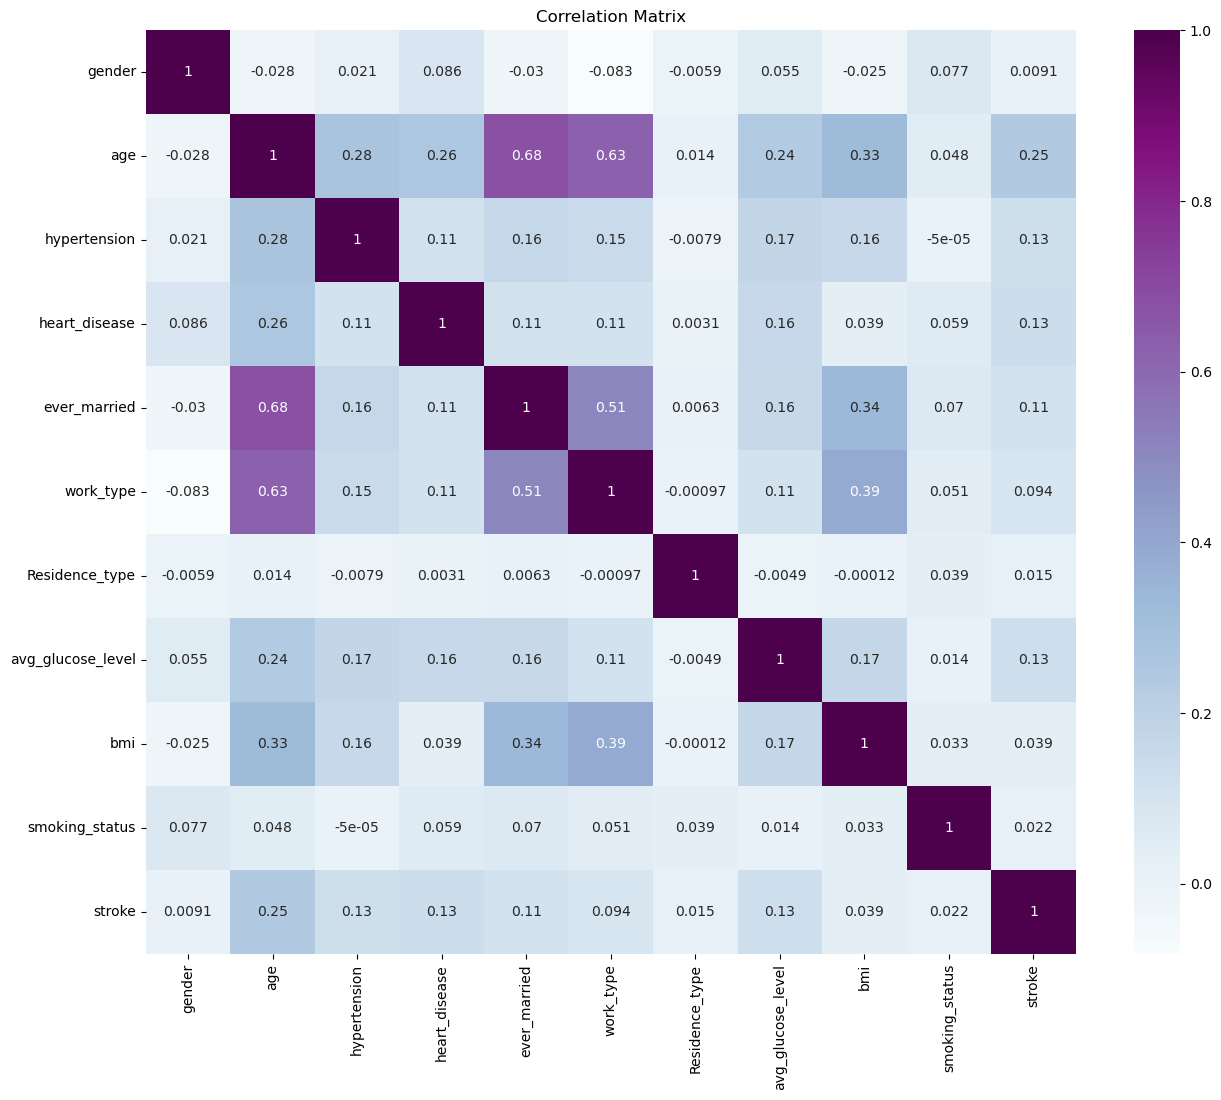

In [11]:
correlation_matrix(df, (15,12))

- This chart helps us identify correlations between variables, which influence the performance of predictive models. Variables that are not correlated with our target could be redundant, and highly correlated variables used for training should be filtered.

- The variable age shows the highest correlations with other important variables such as work_type, BMI, and stroke.

- Variables like hypertension, heart disease, and average glucose level have lower correlations with the target variable (stroke), but they are still relevant for predictive analysis since correlation is not the only factor to consider.

In [12]:
df = df.drop(columns = ['gender', 'Residence_type', 'smoking_status', 'ever_married'])

- These columns are removed because they do not show a relevant correlation with the target variable. In some cases, variables like gender and Residence_type may not provide significant differences in the model and could generate noise.

In [13]:
df.head()

,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,stroke
0,67.0,0,1,3,228.69,36.600000,1
1,61.0,0,0,4,202.21,28.893237,1
2,80.0,0,1,3,105.92,32.500000,1
3,49.0,0,0,3,171.23,34.400000,1
4,79.0,1,0,4,174.12,24.000000,1


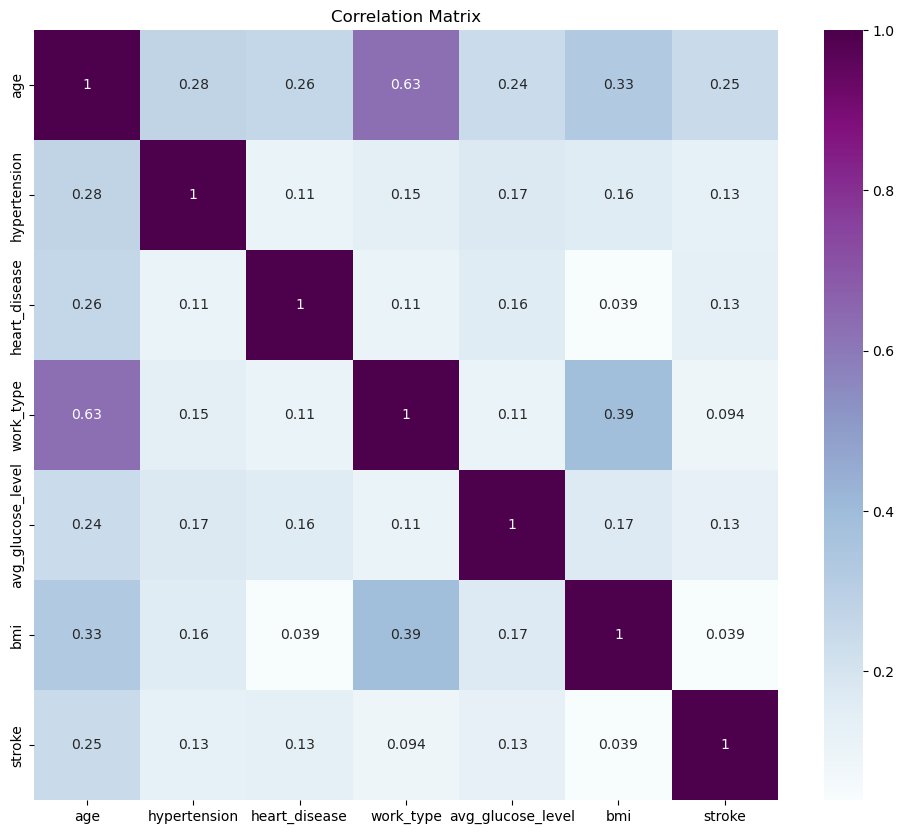

In [14]:
correlation_matrix(df, (12,10))

# Data visualization

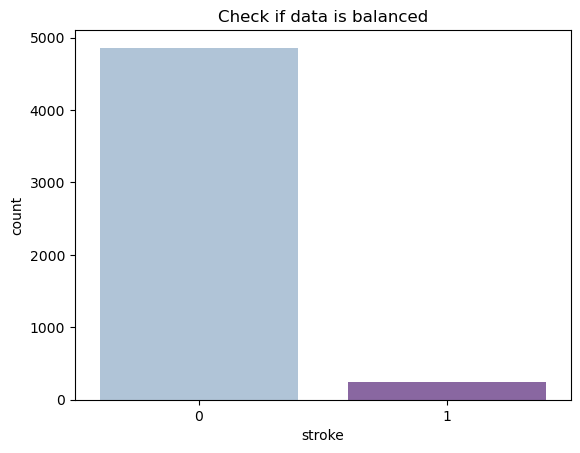

In [15]:
sns.countplot(data = df , x='stroke' ,  palette = 'BuPu')
plt.title("Check if data is balanced")
plt.show()

- The chart shows a significant imbalance in the target variable. There are many more instances of class 0 (did not have a stroke) compared to class 1 (had a stroke).

- This imbalance will be a key factor. Training predictive models with imbalanced data can lead to a bias towards the majority class, resulting in inadequate performance for predicting the minority class (stroke = 1).

- We will conduct a preliminary analysis of predictive models without modifying the class balance to get a first impression of the model's performance. Later, we will apply oversampling techniques, such as SMOTE, to balance the classes.

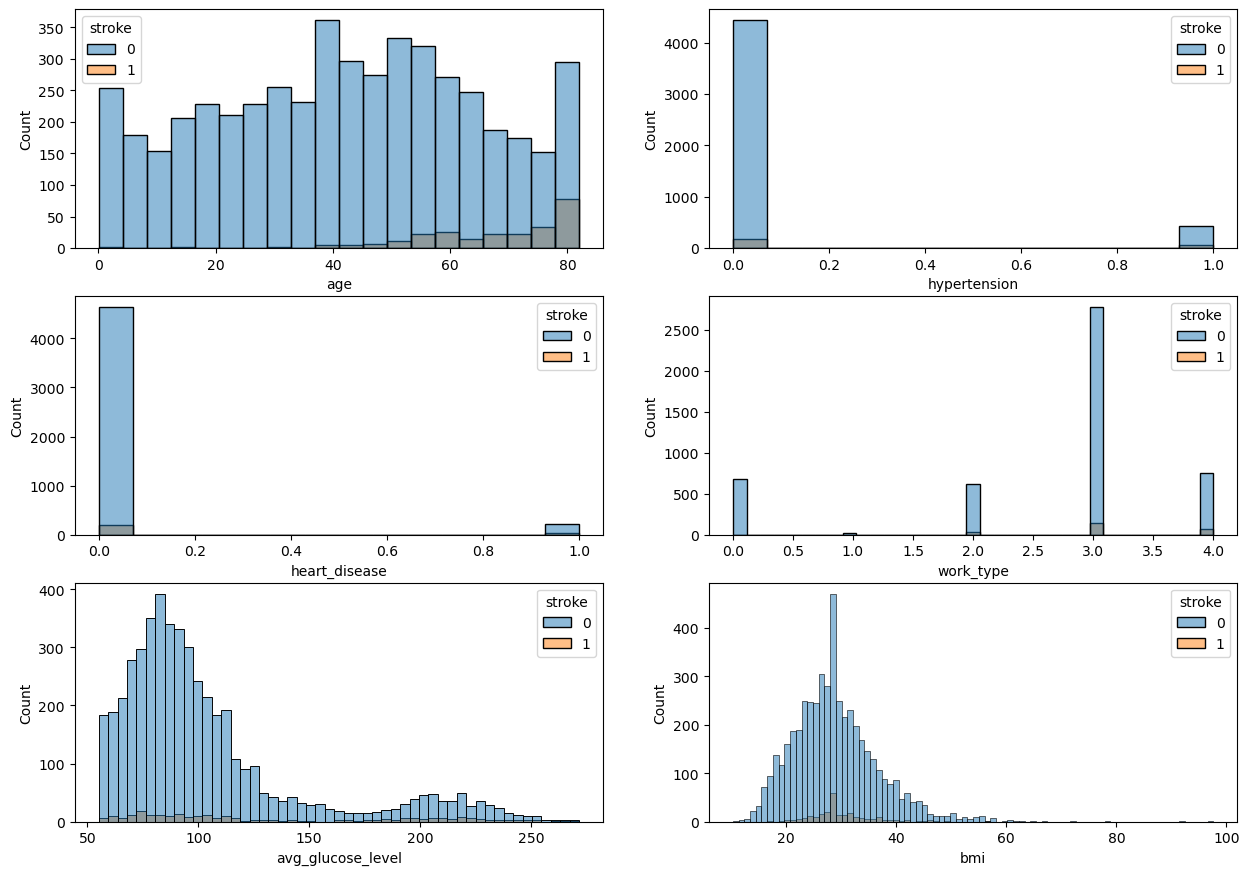

In [16]:
histogram(df)

- Age has a relatively wide distribution, but strokes seem to be more concentrated in patients over 60 years old, which is consistent with known stroke risk factors.

- Most patients do not have hypertension or heart disease. However, among patients who suffered a stroke, there is a higher proportion of those with these risk factors, which is expected since both conditions are known stroke risk factors.

- Most patients work in the private sector, with lower representation in other sectors. However, strokes seem to be more distributed in our classification of jobs related to stress, which appears to validate our label encoding distribution.

- Glucose levels have a right-skewed distribution, with some patients showing very high levels. Stroke patients seem to have higher average glucose levels.

- BMI distribution is relatively symmetric, with most patients in a normal range. However, patients who have suffered a stroke tend to cluster in the higher BMI range, indicating a possible correlation between obesity and stroke risk.

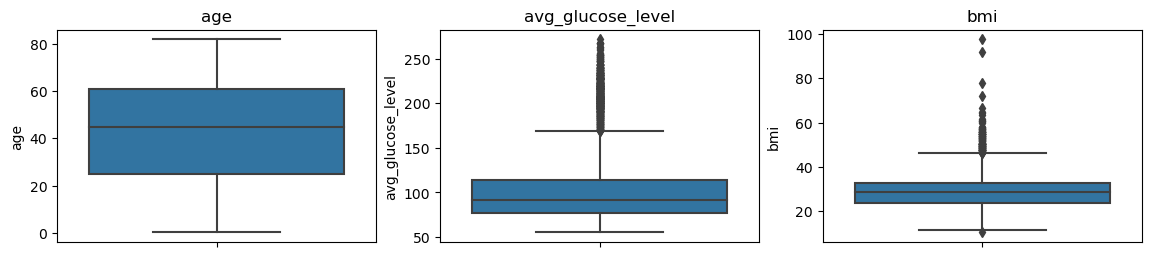

In [17]:
boxplot_outliers(df)

- The variable age has a reasonably uniform distribution, without significant outliers. The median is around 50 years.

- The average glucose level shows a considerable number of outliers above the expected range. This could indicate patients with health conditions related to metabolic disorders, such as diabetes.

- Although most BMI values are concentrated in a normal range (20-40), there is also a considerable number of outliers, suggesting the presence of patients with extreme obesity or underweight.

# Models

- We set up several machine learning algorithms to predict the target variable stroke. We have selected six common classification models, covering both linear and non-linear methods.

In [18]:
X = df.drop('stroke', axis=1) 
y = df['stroke']

- First, we separate the independent variables (X) from the target variable (y).

    - 'X' contains all the features from the dataset except the target variable. These are the features that the models will use to make their predictions.
    
    - 'y' is the target variable, which indicates whether a patient has suffered a stroke (1) or not (0).

In [19]:
models = {
  'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
  'Decision Tree': DecisionTreeClassifier(random_state=42),
  'Random Forest': RandomForestClassifier(random_state=42),
  'SVM': SVC(random_state=42),
  'KNN': KNeighborsClassifier(),
  'NB' : GaussianNB(),
  'Bagging': BaggingClassifier(DecisionTreeClassifier(),n_estimators=100),
  'AdaBoost': AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))
}

- Logistic Regression is a linear model that is easy to interpret and is often effective in binary classification problems.

- Decision Tree is a non-linear model that creates a decision tree based on the features of the dataset.

- Random Forest is an ensemble model that combines several decision trees to improve accuracy and reduce overfitting.

- SVM (Support Vector Machine) is a linear and non-linear model that aims to maximize the margins between classes, useful when the classes are well separated.

- KNN (K-Nearest Neighbors) is an instance-based model that classifies points based on their closest neighbors.

- Naive Bayes (NB) is a probabilistic model that assumes independence between features. It is effective in problems with simple distributions and is computationally efficient.

- Bagging (Bootstrap Aggregating) is an ensemble model that trains multiple decision trees on different subsets of the training data, helping reduce variance and improve accuracy.

- AdaBoost is an ensemble model that fits decision trees sequentially, where each tree tries to correct the errors of its predecessor. It performs well with non-linear relationships and can improve the performance of weak models.

## Without balance

- Before applying the oversampling technique, we will evaluate the performance of the models using the original data. This will give us a first impression of the models' behavior without addressing the class imbalance.

In [20]:
results_df, conf = testing_models(X, y, models, 0)

- This function trains and evaluates several machine learning models. For each model, the function tests different preprocessing combinations:

    - With and without outliers (2 configurations).

    - Three types of scaling: No scaling, Standardization, Normalization (3 configurations).

        - Standard scaling is performed using StandardScaler, and normalization is done with MinMaxScaler.

    - The function also includes an option for class balancing techniques, such as SMOTE or SMOTEENN, though in this case no balancing (0) was applied.

    - In total, 6 tests are run for each model, providing a detailed view of how the models behave under different conditions.

- The data is split into training and test sets (80% training, 20% test) in each preprocessing scenario.

- The function returns a DataFrame (results_df) containing the key metrics (Accuracy, Precision, Recall, and F1score) for each model in the various configurations, and a dictionary (conf) with the corresponding confusion matrices to evaluate performance in each scenario.

In [21]:
results_df.sort_values(by='Precision' , ascending=False).style.background_gradient(cmap='BuPu')

,Model,Outliers,Scaling,Accuracy,Precision,Recall,F1score
14,Bagging,With Outliers,Standardization,0.940313,0.555556,0.080645,0.140845
26,Random Forest,Without Outliers,No Scaling,0.959044,0.500000,0.027778,0.052632
34,Random Forest,Without Outliers,Standardization,0.959044,0.500000,0.027778,0.052632
36,KNN,Without Outliers,Standardization,0.959044,0.500000,0.027778,0.052632
42,Random Forest,Without Outliers,Normalization,0.959044,0.500000,0.027778,0.052632
30,Bagging,Without Outliers,No Scaling,0.959044,0.500000,0.055556,0.100000
6,Bagging,With Outliers,No Scaling,0.938356,0.428571,0.048387,0.086957
10,Random Forest,With Outliers,Standardization,0.938356,0.400000,0.032258,0.059701
22,Bagging,With Outliers,Normalization,0.937378,0.400000,0.064516,0.111111
18,Random Forest,With Outliers,Normalization,0.938356,0.400000,0.032258,0.059701


- Precision is the key metric for this analysis, as minimizing false negatives is critical in stroke prediction. While F1-score is useful for balancing Precision and Recall, our focus remains on identifying stroke cases accurately without generating too many false positives.

- Bagging and Random Forest emerged as the top-performing models. Both achieved relatively high precision, with Bagging showing a Precision of around 0.55 in some configurations.
    
    - However, their Recall remains low, indicating that although they correctly identify stroke cases, they miss a significant portion of positive cases. These models performed best when outliers were included and Standardization was applied.

- KNN and Random Forest without outliers performed similarly, with a Precision of 0.50 but very low Recall (~0.03). This indicates that these models focus heavily on the majority class (no stroke) but struggle to detect the minority class (stroke), as seen in their low F1-score.

- Naive Bayes, although traditionally good at handling binary classification problems, performs poorly in this context. While it achieves a reasonable Recall (~0.47), its Precision is very low, leading to a higher number of false positives, and its F1-score does not surpass 0.30 in most configurations.

- Decision Tree models are in the middle range of performance, with an F1-score around 0.23 when no outliers and standardization are applied. However, their Precision and Recall remain lower compared to Bagging and Random Forest, making them less effective for detecting stroke cases.

- SVM and Logistic Regression performed the worst, with F1-scores of 0 across multiple configurations. Although they show high accuracy (~0.95), their inability to correctly identify any stroke cases makes them inadequate for this imbalanced dataset.

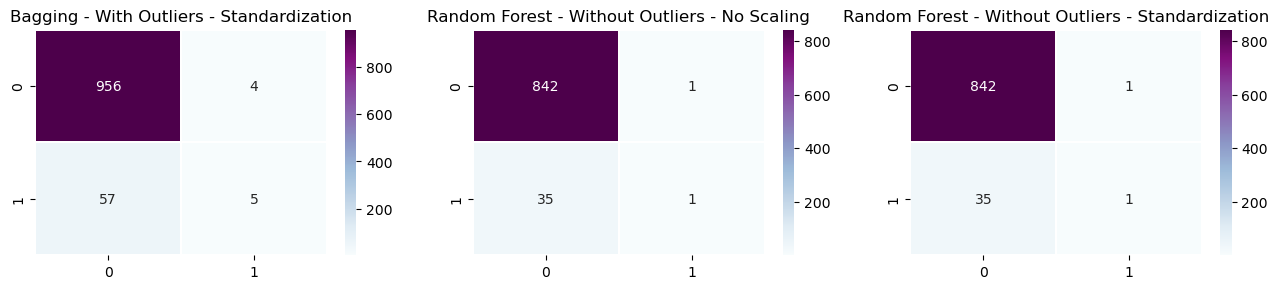

In [22]:
compare_confusion_matrix(results_df, conf)

- Correct Classification of the Majority Class (No Stroke): The model performs well in classifying patients without stroke (class 0), correctly identifying between 842 to 956 cases out of 960 in all configurations.

- False Positives: There are 1 to 4 false positives, where patients without stroke are incorrectly classified as having had one.

- Challenges with Stroke Cases (Class 1): The model struggles with stroke cases, correctly identifying only 1 to 5 true positives.

- False Negatives: It generates 35 to 57 false negatives, where stroke patients are misclassified as not having had a stroke.

- Conclusion: The model performs well for the majority class but struggles with the minority class (stroke), reinforcing the need for techniques like SMOTE to address class imbalance and improve predictions for stroke cases.

## Oversampling

In [23]:
sm=SMOTE(random_state=42)
X_os,y_os=sm.fit_resample(X,y)

- SMOTE is an oversampling technique that generates synthetic examples for the minority class (in this case, patients who have suffered a stroke) instead of simply duplicating existing samples.

    - This helps to balance the dataset and reduce the bias towards the majority class.

- X_os and y_os are the new balanced datasets. After applying SMOTE, both the majority class (no stroke) and the minority class (stroke) will have the same number of samples.

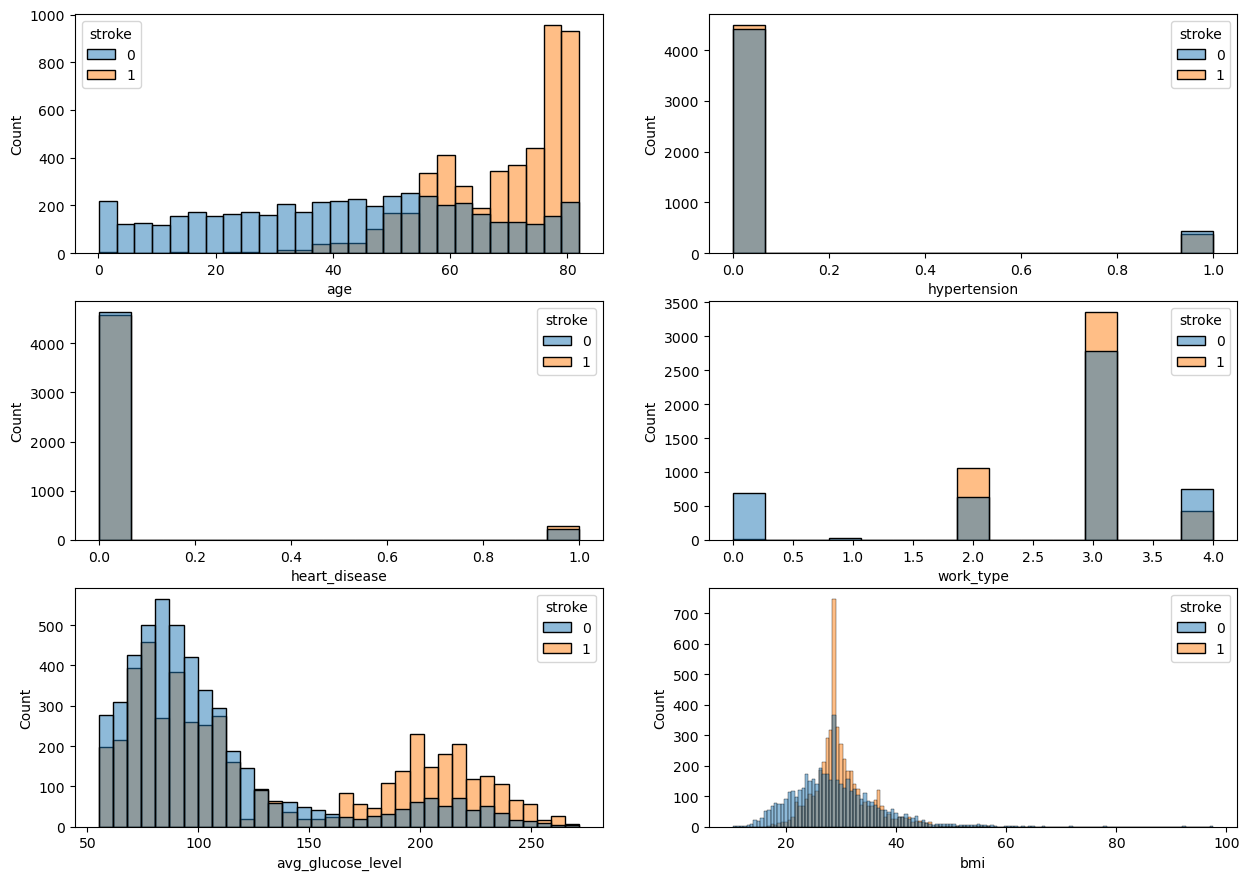

In [24]:
df_os = X_os.copy()
df_os['stroke'] = y_os
histogram(df_os)

- Age: After applying SMOTE, the distribution remains relatively wide, but stroke cases are now evenly distributed across different age groups. There is still a higher concentration of stroke cases among patients over 60, aligning with known stroke risk factors.

- Hypertension and Heart Disease: The distribution for these risk factors has been balanced, showing a more equal representation of stroke cases across patients with and without these conditions. This allows the model to better learn the impact of these risk factors on stroke prediction.

- Work Type: Stroke cases are now more balanced across different work types, particularly for the "Private" sector. The distribution aligns better with the stress-related work type categories, offering the model a clearer understanding of the relationship between job types and stroke risk.

- Glucose Levels: The distribution of glucose levels shows a more balanced representation of stroke cases across different levels, though the concentration of stroke cases remains higher in patients with elevated glucose levels, further reinforcing the association between high glucose levels and stroke risk.

- BMI: The BMI distribution is now more evenly spread, with stroke cases balanced across different BMI ranges. However, there is still a clustering of stroke cases in the higher BMI range, indicating that a higher BMI is a consistent risk factor even after class balancing.

In [25]:
y_os.value_counts()

1    4861
0    4861
Name: stroke, dtype: int64

In [26]:
results_os_df, conf_os = testing_models(X, y, models, 1)

In [27]:
results_os_df.sort_values(by='Precision' , ascending=False).style.background_gradient(cmap='BuPu')

,Model,Outliers,Scaling,Accuracy,Precision,Recall,F1score
17,Decision Tree,With Outliers,Normalization,0.882583,0.204082,0.322581,0.250000
6,Bagging,With Outliers,No Scaling,0.886497,0.200000,0.290323,0.236842
2,Random Forest,With Outliers,No Scaling,0.888454,0.190476,0.258065,0.219178
4,KNN,With Outliers,No Scaling,0.814090,0.186275,0.612903,0.285714
23,AdaBoost,With Outliers,Normalization,0.865949,0.179487,0.338710,0.234637
34,Random Forest,Without Outliers,Standardization,0.907850,0.173913,0.333333,0.228571
14,Bagging,With Outliers,Standardization,0.883562,0.172414,0.241935,0.201342
0,Logistic Regression,With Outliers,No Scaling,0.773973,0.171206,0.709677,0.275862
10,Random Forest,With Outliers,Standardization,0.878669,0.170213,0.258065,0.205128
12,KNN,With Outliers,Standardization,0.812133,0.164948,0.516129,0.250000


- Precision remains the primary metric in this analysis since minimizing false negatives is critical in stroke prediction. After applying SMOTE, the results indicate a general decrease in precision for many models, with Decision Tree (with outliers and normalization) achieving the highest precision of 0.2041. 

    - However, this comes with a relatively low recall of 0.3226, meaning it catches some stroke cases but still struggles with false positives and false negatives. The F1-score for Decision Tree in this configuration is 0.25, reflecting a balance between precision and recall but showing there is still room for improvement.

- Bagging, when tested with outliers and no scaling, achieves a precision of 0.2 but with a lower recall of 0.2903. This results in an F1-score of 0.2368, indicating a slight preference for precision over recall but overall struggling to identify enough true positive stroke cases.

- Random Forest, despite its reputation as a strong performer, shows a relatively low precision of 0.1905 with no scaling and with outliers. Its recall is 0.2581, and the F1-score is 0.2192, suggesting that while it avoids some false positives, it still misses many stroke cases. 

    - Interestingly, Random Forest performs similarly in multiple configurations, including with and without outliers and various scaling methods, but none yield significantly better precision.

- K-Nearest Neighbors (KNN) reaches a precision of 0.1863 with no scaling and outliers but achieves a higher recall of 0.6129. This means KNN catches more stroke cases but at the cost of higher false positives, which lowers its precision. The F1-score of 0.2857 highlights that while recall is high, precision needs improvement.

- Logistic Regression, when tested with outliers and no scaling, shows a precision of 0.1712, with a notably high recall of 0.7097. This results in an F1-score of 0.2759, reflecting its ability to catch many stroke cases, but the increase in false positives drives precision down. Logistic Regression demonstrates a similar pattern across multiple configurations, where it manages to improve recall but sacrifices precision.

- SVM and Naive Bayes perform similarly, with precision scores around 0.1520-0.1649. Their recall values are relatively high, but this comes at the cost of precision, meaning they correctly identify more stroke cases but also classify more false positives. The F1-scores for these models remain below 0.27, indicating a poor balance between precision and recall in our context.

- AdaBoost, while achieving moderate precision values, shows overall lower performance with precision values around 0.1395 and recall fluctuating between 0.2097 and 0.3333. The F1-scores hover around 0.16-0.23, indicating that the model struggles to find a balance between precision and recall in this dataset.

- In conclusion, SMOTE does not lead to significant improvements in precision across the tested models. In many cases, it increases recall at the cost of precision, generating more false positives. Given that minimizing false negatives is a key priority in stroke prediction, Decision Tree with outliers and normalization provides the highest precision, but it still requires further refinement to improve recall without sacrificing too much precision.

    - Models like Random Forest and KNN, while robust in other scenarios, show relatively low precision after oversampling, making them less suitable for this particular task where false negatives are critical.

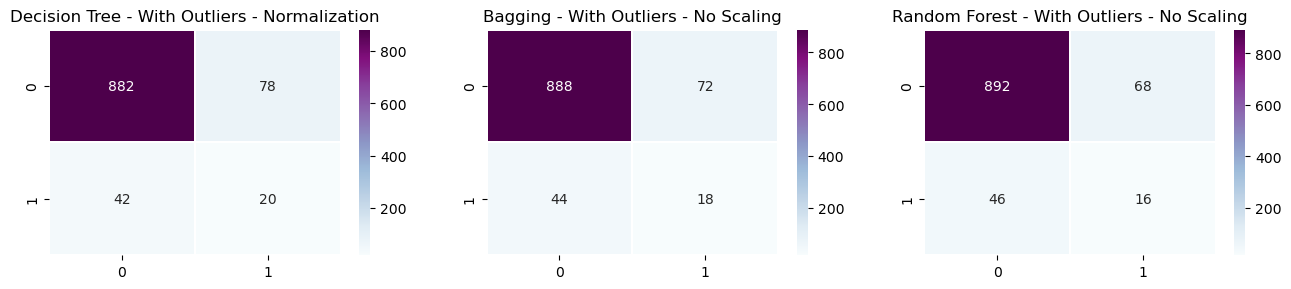

In [28]:
compare_confusion_matrix(results_os_df, conf_os)

- After applying SMOTE and testing various configurations (with outliers, standardization, and no scaling), the model shows significant improvements in identifying stroke cases.

- For class 0 (no stroke), the model correctly classifies 888-892 cases, reducing false positives to 68-78 across different configurations. This is a clear improvement compared to the pre-SMOTE analysis, where the model had a higher number of false positives.

- For class 1 (stroke), the model now correctly identifies 16-20 stroke cases, which is a notable improvement over the previous results where it failed to correctly identify as many cases. Despite these improvements, some false negatives remain, meaning the model still misses some stroke cases but performs significantly better than before.

- Overall, after applying SMOTE, the recall improves, allowing the model to catch more stroke cases. However, precision remains an important metric, and there is a slight trade-off with more false positives, but the balance between detecting stroke cases and minimizing false positives has improved.

# Under y Over Sampling

In [29]:
smote_enn = SMOTEENN(random_state=42, sampling_strategy=0.9)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

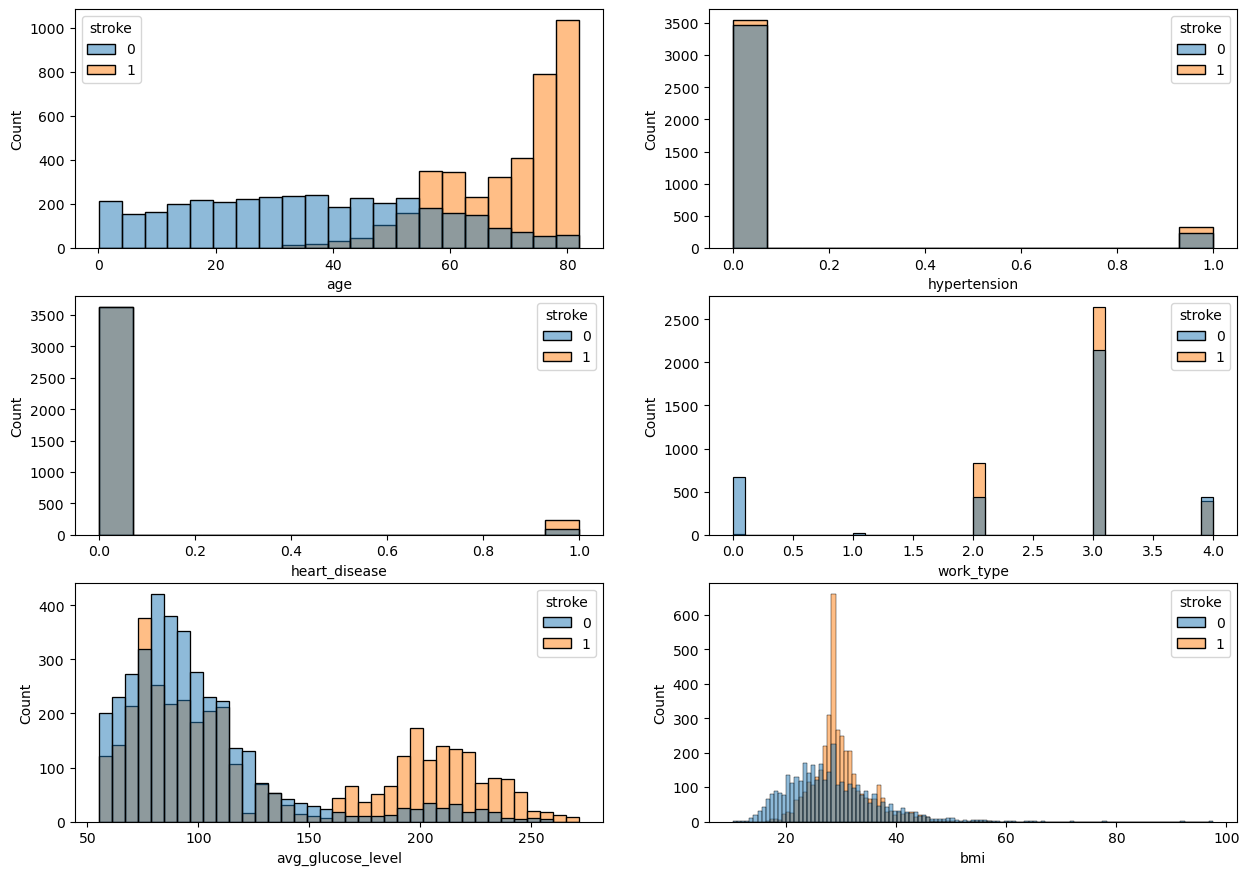

In [30]:
df_resampled = X_resampled.copy()
df_resampled['stroke'] = y_resampled
histogram(df_resampled)

In [31]:
y_resampled.value_counts()

1    3864
0    3709
Name: stroke, dtype: int64

In [32]:
results_resampled_df, conf_resampled = testing_models(X, y, models, 2)

In [33]:
results_resampled_df.sort_values(by='Precision' , ascending=False).style.background_gradient(cmap='BuPu')

,Model,Outliers,Scaling,Accuracy,Precision,Recall,F1score
18,Random Forest,With Outliers,Normalization,0.835616,0.188235,0.516129,0.275862
14,Bagging,With Outliers,Standardization,0.831703,0.187500,0.532258,0.277311
9,Decision Tree,With Outliers,Standardization,0.827789,0.183333,0.532258,0.272727
10,Random Forest,With Outliers,Standardization,0.833659,0.182353,0.500000,0.267241
2,Random Forest,With Outliers,No Scaling,0.836595,0.181818,0.483871,0.264317
15,AdaBoost,With Outliers,Standardization,0.823875,0.175824,0.516129,0.262295
22,Bagging,With Outliers,Normalization,0.829746,0.174419,0.483871,0.256410
23,AdaBoost,With Outliers,Normalization,0.827789,0.172414,0.483871,0.254237
17,Decision Tree,With Outliers,Normalization,0.822896,0.171271,0.500000,0.255144
4,KNN,With Outliers,No Scaling,0.771037,0.166667,0.693548,0.268750


- Precision remains the primary metric in this analysis since minimizing false negatives is critical in stroke prediction. After applying SMOTEENN, the results indicate a decrease in precision for many models, with Random Forest (with outliers and normalization) achieving the highest precision of 0.1882.

    - However, this comes with a higher recall of 0.5161, meaning it catches more stroke cases but at the cost of generating more false positives. The F1-score for Random Forest in this configuration is 0.2759, reflecting a trade-off between precision and recall.

- Bagging, when tested with outliers and standardization, reaches a precision of 0.1875 with a recall of 0.5323, resulting in an F1-score of 0.2773. This balance shows Bagging can identify more true positive stroke cases, but at the expense of more false positives.

- Decision Tree, with outliers and standardization, has a precision of 0.1833 and recall of 0.5323. The F1-score is 0.2727, showing a similar pattern to Bagging, where the model catches more stroke cases but sacrifices precision due to false positives.

- K-Nearest Neighbors (KNN) reaches a precision of 0.1667 with no scaling and outliers but has a higher recall of 0.6935. This leads to an F1-score of 0.2688, indicating that KNN performs well in identifying stroke cases but at the expense of higher false positives, lowering precision.

- Logistic Regression, tested with outliers and no scaling, shows a precision of 0.1617 with a high recall of 0.7903. The resulting F1-score is 0.2685, indicating strong recall performance but a significant drop in precision due to the higher number of false positives.

- SVM and Naive Bayes perform similarly, with precision scores between 0.1511 and 0.1584. Their recall values remain high (around 0.7742–0.8065), but the precision remains low due to the false positives, leading to F1-scores below 0.26.

- AdaBoost achieves precision around 0.1494 with varying recall values between 0.4194 and 0.5161. F1-scores range between 0.22–0.26, indicating that while it can identify some stroke cases, the number of false positives remains an issue.

- In conclusion, SMOTEENN did not significantly improve precision across the models. Although it boosts recall, it tends to increase false positives, which reduces precision. Since minimizing false negatives is a key goal in stroke prediction, Random Forest with outliers and normalization provides the highest precision, but further improvement is needed to enhance recall without sacrificing too much precision.

    - Models like Bagging and KNN show moderate performance with better recall but at the cost of more false positives. Overall, Random Forest continues to show robust results, but refining the model's balance between precision and recall is necessary to meet the specific goals of this task.

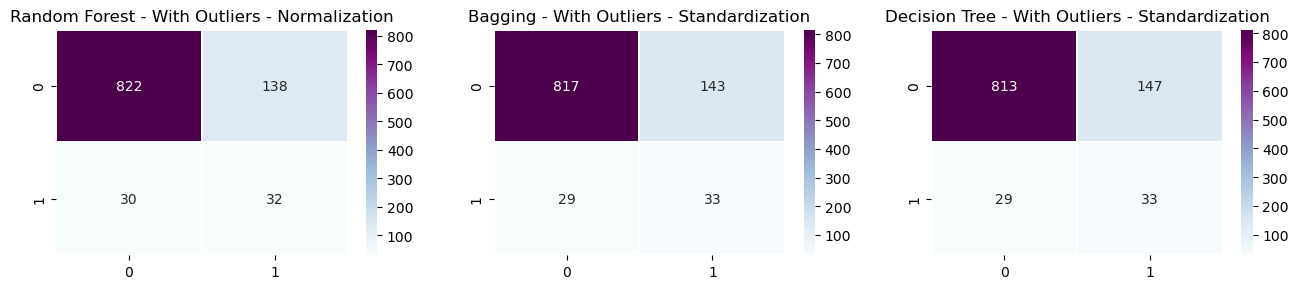

In [34]:
compare_confusion_matrix(results_resampled_df, conf_resampled)

- After applying SMOTEENN and testing various configurations (with outliers and using different scaling techniques like standardization and normalization), the model shows moderate improvements in identifying stroke cases compared to previous evaluations.

- For class 0 (no stroke), the models correctly classify 813-822 cases, with Random Forest performing the best, reducing false positives to 138-147 across different configurations. However, this still results in a higher number of false positives compared to the pre-SMOTEENN analysis, indicating a precision trade-off.

- For class 1 (stroke), the models correctly identify 29-33 stroke cases, a notable improvement compared to pre-SMOTE and pre-SMOTEENN results. Despite these improvements, false negatives remain, with 29-33 missed stroke cases depending on the model, meaning the models still struggle with identifying all stroke cases but show overall better recall.

- Overall, after applying SMOTEENN, the recall has improved, allowing the models to catch more stroke cases. However, the increased false positives across all models, particularly in Bagging and Decision Tree, show that precision remains a challenge, as models now sacrifice some precision to improve recall. Random Forest achieves the best balance between reducing false positives and improving recall, making it slightly more robust in this setting